## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Atomic fraction

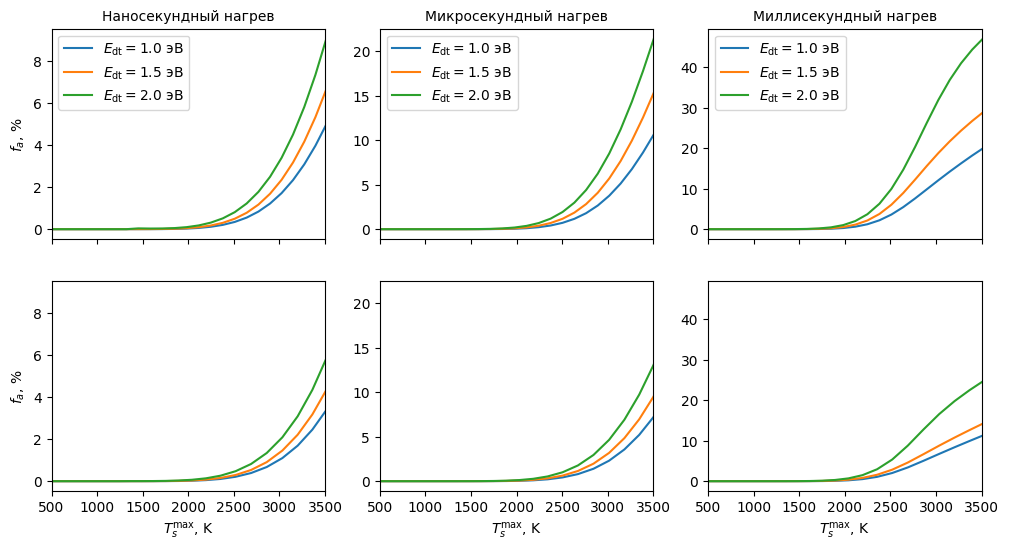

In [2]:
fig, axs = plt.subplots(2, 3, figsize=(12,6), sharex="col", sharey="col")

durations = ["ns", "us", "ms"]
titles = ["Наносекундный нагрев", "Микросекундный нагрев", "Миллисекундный нагрев"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dts = [1.0, 1.5, 2.0]
materials = ["W", "Be"]
phi = 1
eta_tr = 1e-2


for g, mat in enumerate(materials):
    for i in range(3):

        E = E_maxs[i] * np.linspace(0, 1, 26, endpoint=True)

        for k, E_dt in enumerate(E_dts):
            fa = np.zeros_like(E)
            Tmax = np.zeros_like(E)

            for j in range(3, 26):
                #my_model = LID_simulation(E[j], durations[i], mat, E_dt, eta_tr, phi, "./results2", is_txt=False)

                filename_flux = (
                    f"./results/fluxes_{mat}_{durations[i]}_E{E[j]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
                )
                filename_data = (
                    f"./results/data_{mat}_{durations[i]}_E{E[j]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
                )
                fluxes = np.loadtxt(fname=filename_flux, skiprows=0, delimiter=",")
                results = np.loadtxt(fname=filename_data, skiprows=1, delimiter=",")

                T = results[:, 3]

                t = fluxes[:, 0]
                Jat = fluxes[:, 1]
                J_mol_s = fluxes[:, 2]
                J_mol_sb = fluxes[:, 3]
                J_mol_b = fluxes[:, 4]
                J_des = fluxes[:, 5]

                N_a = np.trapz(Jat, x=t)
                N_des = np.trapz(J_des, x=t)

                if N_a < 1e10:
                    fa[j] = 0
                else:
                    fa[j] = N_a / N_des * 100

                Tmax[j] = T.max()

            axs[g][i].plot(Tmax, fa, label=fr"$E_{{\mathrm{{dt}}}}={E_dt}$ эВ")

for i in range(3):
    axs[0][i].set_title(titles[i], fontsize=10)
    axs[1][i].set_xlabel(r"$T_s^{\mathrm{max}}$, K")

    axs[1][i].set_xlim(500, 3500)
    axs[0][i].legend(loc="upper left")

axs[0][0].set_ylabel(r"$f_a$, %")
axs[1][0].set_ylabel(r"$f_a$, %")
plt.show()

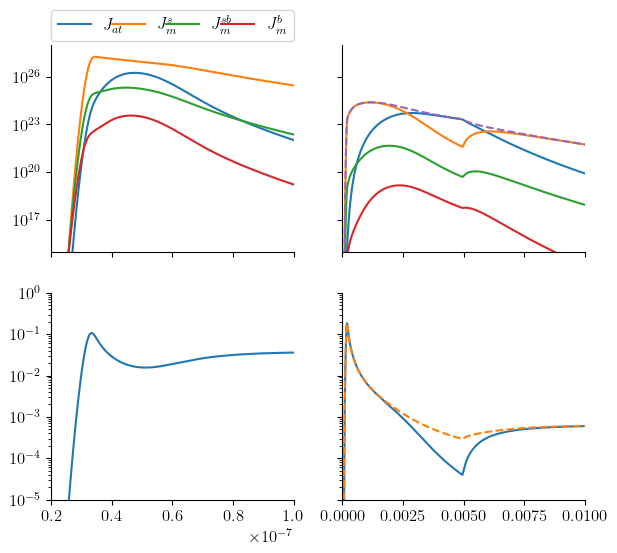

In [9]:
from model import LID_simulation
import numpy as np
import matplotlib.pyplot as plt
from sub_functions.materials import W

mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
        ]
    ),
    "font.size": 12,
    "font.family": "Times New Roman",
    "axes.spines.right": False,
    "axes.spines.top": False,
}

plt.rcParams.update(mpl_params)

mm2inch = 0.1 / 2.54

fig, ax = plt.subplots(2,2, sharey="row", sharex="col", figsize=(175*mm2inch, 150*mm2inch))

durations = ["ns", "ms"]
E_maxs = [10.2e3, 3.496e6]
E_dt = 1.5
eta_tr = 1e-2
phi = 1
mat = "W"

for i in range(2):
    my_model = LID_simulation(E_maxs[i], durations[i], mat, E_dt, eta_tr, phi, "./results2", is_txt=False)

    filename = (
        f"./results/data_{mat}_{durations[i]}_E{E_maxs[i]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
    )
    results = np.loadtxt(fname=filename, skiprows=1, delimiter=",")



    t = np.array(results[:, 0])
    cs = np.array(results[:, 1])
    T = np.array(results[:, 3])
    cm = np.array(results[:, 4])

    Jat = my_model.J_a(T, cs)
    Jmol_s = my_model.J_m_s(T, cs)
    Jmol_sb = 2 * my_model.J_m_sb(T, cs, cm)
    Jmol_b = my_model.J_m_b(T, cm)


    ax[0][i].plot(t, Jat, label=r"$J_{at}$")
    ax[0][i].plot(t, Jmol_s, label=r"$J_{m}^s$")
    ax[0][i].plot(t, Jmol_sb, label=r"$J_{m}^{sb}$")
    ax[0][i].plot(t, Jmol_b, label=r"$J_{m}^{b}$")
    

    ax[1][i].plot(t, cs / W().n_surf, label="mol_b")

filename = (
    f"./results_no_sub/fluxes_{mat}_{durations[1]}_E{E_maxs[1]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
)
filename_res = (
    f"./results_no_sub/data_{mat}_{durations[1]}_E{E_maxs[1]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"    
)
fluxes = np.loadtxt(fname=filename, skiprows=0, delimiter=",")
results = np.loadtxt(fname=filename_res, skiprows=1, delimiter=",")

t = fluxes[:, 0]
Jmol_s = fluxes[:, 2]
cs = results[:, 1]

ax[0][1].plot(t, Jmol_s, label=r"$J_{m}^s$", ls="dashed")
ax[1][1].plot(t, cs / W().n_surf, label=r"$J_{m}^s$", ls="dashed")

ax[0][0].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
ax[0][0].set_xlim(20e-9, 100e-9)
ax[0][1].set_xlim(0, 10e-3)
ax[0][0].set_ylim(1e15, 1e28)
ax[0][0].set_yscale("log")
ax[1][0].set_ylim( 1e-5, 1)
ax[1][0].set_yscale("log")

plt.savefig('../../../Thesis/images/fluxes.pdf')
plt.show()

# Analytics

In [1]:
from scipy.optimize import fsolve
import numpy as np

temp = np.linspace(500, 4000, num=100, endpoint=True)
flux = np.logspace(1e16, 1e28, num=100, endpoint=True)

T, F = np.meshgrid(temp, flux)

fa = np.zeros_like(T)
theta = np.zeros_like(T)
beta = np.zeros_like(T)

for i, TT in enumerate(T):
    for j, FF in enumerate(F):
        theta[i][j], beta[i][j] = fsolve(eq, T[i], F[j])
        
        
fa = theta ** 2 * K_a(T)
plt.pcolormesh(T, F, fa)



/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/function_base.py:284: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


NameError: name 'eq' is not defined

In [8]:
from sub_functions.materials import W
from festim import k_B
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

mat = W()

Q_c = lambda cs: mat.Q_c(cs)
E_c = mat.E_c
Q_s = mat.Q_s
E_s = mat.E_s
E_d = mat.E_d
n_surf = mat.n_surf

def K_bs(T):
    return mat.nu_D / mat.nu_0 * np.exp(-(E_s - Q_s) / k_B / T)
    
def K_sb(T, cs):
    return np.exp(-(E_s - Q_c(cs)) / k_B / T)

def K_m_s(T, cs):
    return np.exp(-2 *(E_c - Q_c(cs)) / k_B / T)

def K_m_sb(T, cs):
    return mat.nu_D / mat.nu_0 * np.exp(-((E_c - Q_c(cs) + E_s - Q_s)) / k_B / T)

def K_m_b(T):
    return mat.nu_D / mat.nu_0 * np.exp(-2 * (E_s - Q_s) / k_B / T)

def K_a(T, cs):
    return np.exp(-(E_d - Q_c(cs)) / k_B / T)

def equations(vars, F, T):
    x, y = vars
    cs = x * n_surf

    eq1 = y * (1 - x) * K_bs(T) - x * (1 - y) * K_sb(T, cs) + 2 * y**2 * K_m_b(T) + x * y * K_m_sb(T, cs) - F
    eq2 = y * (1 - x) * K_bs(T) - x * (1 - y) * K_sb(T, cs) - 2 * x**2 * K_m_s(T, cs) - x * y * K_m_sb(T, cs) - x * K_a(T, cs)

    return [eq1, eq2]

temp = np.linspace(500, 4000, num=100, endpoint=True)
flux = np.logspace(16, 28, num=100, endpoint=True)

F, T = np.meshgrid(flux, temp)

theta = np.zeros_like(T)
beta = np.zeros_like(T)

initial_guess = [0.1, 0.95]

for i in range(len(F)):
    for j in range(len(F[0])):
        solution = fsolve(equations, initial_guess, args=(F[i][j] / 1e13 / n_surf, T[i][j]))
        
        theta[i][j] = solution[0]
        beta[i][j] = solution[1]


In [6]:
def AtFr_analytical(T, F):
    J0 = mat.nu_0 * mat.n_surf
    F_norm = F / J0

    return K_a(T, 0)**2 / 4 / F_norm / K_m_s(T, 0) * (np.sqrt(1 + 8 * F_norm * K_m_s(T, 0) / K_a(T, 0)**2) - 1)

def theta_analytical(T, F):
    J0 = mat.nu_0 * mat.n_surf
    F_norm = F / J0

    return K_a(T, 0) / 4 / K_m_s(T, 0) * (np.sqrt(1 + 8 * F_norm * K_m_s(T, 0) / K_a(T, 0)**2) - 1)


In [62]:
fig, ax = plt.subplots(figsize=(120 * mm2inch, 90 * mm2inch))

Ja = theta * n_surf * mat.nu_0 * K_a(T, theta * n_surf)
fa = Ja / F * 100
J0 = mat.nu_0 * mat.n_surf
jj = J0 * (2*K_m_s(T,0) + K_a(T,0))

fa_an = AtFr_analytical(T, F) * 100

cm = ax.pcolormesh(F, T, fa, cmap="RdBu_r", shading="gouraud", vmin=0, vmax=100)
cbar = plt.colorbar(cm, ax=ax, ticks=[0, 25, 50, 75, 100])
cbar.ax.set_title(r"$f_a, \%$")

'''cf = ax.contour(F, T, fa_an, levels=[50], linestyles="solid", colors="black", linewidths=2)
ax.scatter(
    cf.get_paths()[0].vertices[::10,0], 
    cf.get_paths()[0].vertices[::10,1],
    marker="s",
    color="limegreen",
    zorder=2)'''

ax.plot(jj, T, ls="dashed", color="tab:red")

ax.axhline(3695, color="white", ls="dotted")
#ax.axhline(2750, color="white", ls="dashed")
#ax.axhline(1650, color="white", ls="dashed")
ax.axhline(1400, color="white", ls="dotted")

ax.text(2e16, 3800, "Плавление вольфрама", ha="left", va="center", color="white")
ax.text(1e23, 1500, "Рекристаллизация", ha="left", va="center", color="white")
ax.text(1e23, 920, r"$\mathbf{\theta=1}$", ha="left", va="center", color="tab:red", rotation=14)
#ax.text(2e16, 2850, "Кипение бериллия", ha="left", va="center", color="white")
#ax.text(1e23, 1750, "Плавление бериллия", ha="left", va="center", color="white")

ax.set_xscale("log")
ax.set_xlim(1e16, 1e28)
ax.set_ylim(500, 4000)
ax.set_xlabel(r"Плотность потока D, $\text{м}^{-2}\,\text{с}^{-1}$")
ax.set_ylabel(r"Температура, К")

plt.savefig("../../../Thesis/images/atomic_fraction_diagram.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

NameError: name 'mm2inch' is not defined

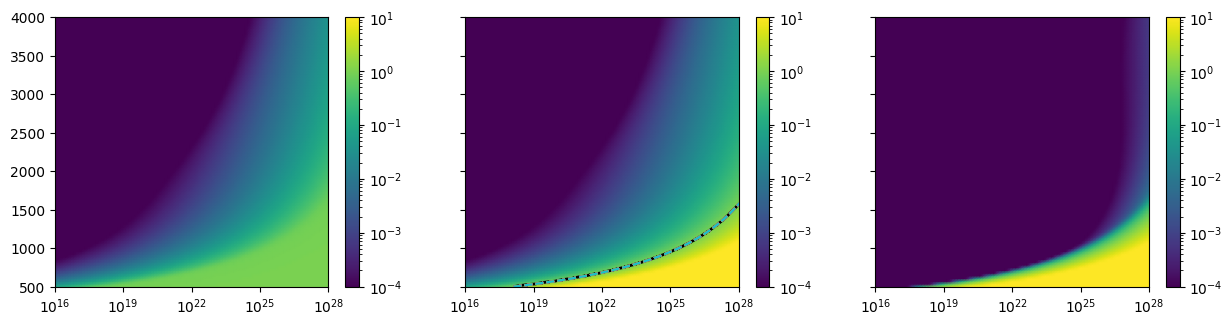

In [40]:
import matplotlib.colors as colors

fig, ax = plt.subplots(1, 3, figsize=(15,3.5), sharex=True, sharey=True)

Ja = theta * n_surf * mat.nu_0 * K_a(T, theta * n_surf)
fa = Ja / F * 100
J0 = mat.nu_0 * mat.n_surf
jj = J0 * (2*K_m_s(T,0) + K_a(T,0))

fa_an = AtFr_analytical(T, F) * 100
theta_an = theta_analytical(T, F)

cm = ax[0].pcolormesh(F, T, theta, cmap="viridis", shading="gouraud", norm=colors.LogNorm(vmin=1e-4, vmax=10))
fig.colorbar(cm, ax=ax[0])

cm = ax[1].pcolormesh(F, T, theta_an, cmap="viridis", shading="gouraud", norm=colors.LogNorm(vmin=1e-4, vmax=10))
fig.colorbar(cm, ax=ax[1])
cf = ax[1].contour(F, T, theta_an, levels=[1], linestyles="solid", colors="black", linewidths=2)
ax[1].plot(jj, T, ls="dashed")

cm = ax[2].pcolormesh(F, T, np.abs(theta-theta_an), cmap="viridis", shading="gouraud", norm=colors.LogNorm(vmin=1e-4, vmax=10))
fig.colorbar(cm, ax=ax[2])

ax[0].set_xscale("log")
ax[0].set_xlim(1e16, 1e28)
ax[0].set_ylim(500, 4000)

plt.show()

5304.0
9384.0
83200.0
147200.0
1976000.0
3496000.0


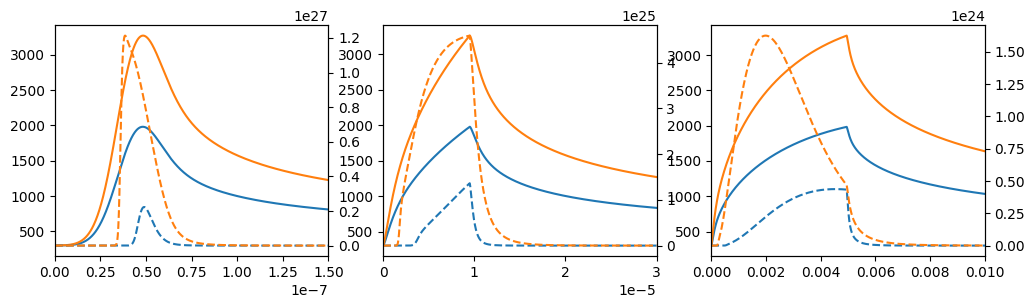

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12,3), sharex="col", sharey="col")

durations = ["ns", "us", "ms"]
titles = ["Наносекундный нагрев", "Микросекундный нагрев", "Миллисекундный нагрев"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dts = [1.0, 1.5, 2.0]
materials = ["W", "Be"]
phi = 1
eta_tr = 1e-2

mat = "W"
for i in range(3):
    tw_ax = axs[i].twinx()
    E = E_maxs[i] * np.linspace(0, 1, 26, endpoint=True)


    for j in [13, 23]:
        #my_model = LID_simulation(E[j], durations[i], mat, E_dt, eta_tr, phi, "./results2", is_txt=False)
        print(E[j])
        filename_flux = (
            f"./results/fluxes_{mat}_{durations[i]}_E{E[j]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
        )
        filename_data = (
            f"./results/data_{mat}_{durations[i]}_E{E[j]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
        )
        fluxes = np.loadtxt(fname=filename_flux, skiprows=0, delimiter=",")
        results = np.loadtxt(fname=filename_data, skiprows=1, delimiter=",")

        T = results[:, 3]
        t = results[:, 0]
        J_des = fluxes[:, 5]
        axs[i].plot(t, T)
        tw_ax.plot(t, J_des, ls="dashed")

axs[0].set_xlim(0,150e-9)
axs[1].set_xlim(0,30e-6)
axs[2].set_xlim(0,10e-3)
plt.show()
